**Group Members:**

1. 20221960 - Renato Bernardino
2. 20221899 - David Duarte


## Task 3 Customer Segmentation

Understanding the diverse needs and behaviours of customers is crucial for targeted marketing, risk assessment, and product development. Customer segmentation can lead to more personalized loan products and better customer satisfaction. 






In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!


### A.1 Data Loading and Preparation


In [3]:
# Load the cleaned data from Task 1
data_path = 'task3_segmentation_data.csv'
data = pd.read_csv(data_path)

print("=" * 60)
print("DATA LOADING")
print("=" * 60)
print(f"Data shape: {data.shape}")
print(f"Columns: {data.shape[1]}")
print(f"Rows: {data.shape[0]:,}")

# Display basic info
print("\nFirst few rows:")
data.head()


DATA LOADING
Data shape: (158790, 84)
Columns: 84
Rows: 158,790

First few rows:


,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,ADDRESS_MISMATCH_REGION,ADDRESS_MISMATCH_CITY,EMPLOYED_AGE_RATIO,NAME_EDUCATION_TYPE_ORD
0,1,1,0,112500.0,1125000.0,33025.5,1125000.0,0.014520,40.0,2.331507,...,0.0,-603.0,False,9.999911,0.293557,0.999999,0,0,0.058288,3
1,0,1,1,162000.0,270000.0,13500.0,270000.0,0.035792,23.0,2.413699,...,0.0,-933.0,False,1.666656,0.083333,0.999996,0,1,0.104943,3
2,0,1,0,157500.0,580500.0,49824.0,580500.0,0.018801,65.0,4.416438,...,0.0,-211.0,True,3.685691,0.316341,0.999998,0,0,0.067945,1
3,0,1,1,121500.0,280170.0,30303.0,247500.0,0.009334,26.0,5.136986,...,0.0,-1719.0,False,2.305907,0.249405,1.131995,0,1,0.197576,2
4,1,1,0,135000.0,135000.0,6750.0,135000.0,0.010006,22.0,1.761644,...,1.0,-573.0,False,0.999993,0.050000,0.999993,0,0,0.080075,1


### A.2 Feature Selection for Segmentation using correlation


We analyzed all variables for correlation, and redundant features were removed by excluding variables with high correlation (greater than 90%) to avoid duplicated information. This is because redundant features would overemphasize certain customer characteristics, distort distance calculations in clustering algorithms, and reduce the interpretability of the resulting segments by effectively counting the same information multiple times.

In [4]:
print("=" * 60)
print("FEATURE SELECTION FOR SEGMENTATION")
print("=" * 60)

# Identify categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# For segmentation, we want to focus on customer characteristics
# Remove highly correlated features to avoid redundancy
print("\nAnalyzing feature correlations...")

# Work with numerical features first
data_numerical = data[numerical_cols].copy()

# Handle missing values
imputer = SimpleImputer(strategy='median')
data_numerical_imputed = pd.DataFrame(
    imputer.fit_transform(data_numerical),
    columns=data_numerical.columns,
    index=data_numerical.index
)

# Calculate correlation matrix
correlation_matrix = data_numerical_imputed.corr().abs()


# Remove only ONE feature per highly correlated pair (no cascading removals)
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

features_to_remove = {
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > 0.9)
}

print(f"\nFeatures to remove due to high correlation: {len(features_to_remove)}")

# Remaining numerical features after correlation filtering
remaining_features = [
    col for col in data_numerical_imputed.columns
    if col not in features_to_remove
]

print(f"Remaining numerical features: {len(remaining_features)}")
print("Remaining features:")
for f in remaining_features:
    print(f"  - {f}")

# Prepare data for clustering
X_segmentation = data_numerical_imputed[remaining_features].copy()
print(f"\n Segmentation data shape: {X_segmentation.shape}")

FEATURE SELECTION FOR SEGMENTATION
Categorical columns: 0
Numerical columns: 83

Analyzing feature correlations...

Features to remove due to high correlation: 35
Remaining numerical features: 48
Remaining features:
  - FLAG_OWN_CAR
  - FLAG_OWN_REALTY
  - CNT_CHILDREN
  - AMT_INCOME_TOTAL
  - AMT_CREDIT
  - AMT_ANNUITY
  - REGION_POPULATION_RELATIVE
  - DAYS_BIRTH
  - DAYS_EMPLOYED
  - DAYS_REGISTRATION
  - DAYS_ID_PUBLISH
  - FLAG_MOBIL
  - FLAG_EMP_PHONE
  - FLAG_WORK_PHONE
  - FLAG_CONT_MOBILE
  - FLAG_PHONE
  - FLAG_EMAIL
  - CNT_FAM_MEMBERS
  - REGION_RATING_CLIENT
  - HOUR_APPR_PROCESS_START
  - REG_REGION_NOT_LIVE_REGION
  - REG_REGION_NOT_WORK_REGION
  - LIVE_REGION_NOT_WORK_REGION
  - REG_CITY_NOT_LIVE_CITY
  - REG_CITY_NOT_WORK_CITY
  - LIVE_CITY_NOT_WORK_CITY
  - APARTMENTS_AVG
  - BASEMENTAREA_AVG
  - YEARS_BEGINEXPLUATATION_AVG
  - YEARS_BUILD_AVG
  - COMMONAREA_AVG
  - ELEVATORS_AVG
  - ENTRANCES_AVG
  - FLOORSMAX_AVG
  - FLOORSMIN_AVG
  - LANDAREA_AVG
  - LIVINGAPARTMEN

All this 48 features were analyzed and we opted to chose 15 features from them based on our domain knowledge of what each feature could gives to the problem

Financial capacity and burden (CREDIT_INCOME_RATIO, ANNUITY_INCOME_RATIO, AMT_INCOME_TOTAL, AMT_CREDIT) capture customer affordability, borrowing pressure, and product suitability, making them the strongest drivers of meaningful segmentation.

Life stage and stability (DAYS_BIRTH, DAYS_EMPLOYED) distinguish young, established, and near-retirement customers, reflecting differences in income stability and long-term financial behaviour.

Household structure, assets, and social risk (CNT_FAM_MEMBERS, CNT_CHILDREN, FLAG_OWN_REALTY, FLAG_OWN_CAR, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE) describe responsibility load, wealth proxies, and peer-risk environments that influence loan needs and default tendencies.

Geographic context and credit structure (REGION_POPULATION_RELATIVE, REGION_RATING_CLIENT, CREDIT_GOODS_RATIO) differentiate urban versus rural settings and consumption-driven versus liquidity-driven borrowing patterns, further refining customer segments.

In [28]:
#handpicked columns based on domain knowledge and correlation analysis
selected_features = [
    "CREDIT_INCOME_RATIO",
    "ANNUITY_INCOME_RATIO",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "CNT_FAM_MEMBERS",
    "CNT_CHILDREN",
    "FLAG_OWN_REALTY",
    "FLAG_OWN_CAR",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "REGION_POPULATION_RELATIVE",
    "REGION_RATING_CLIENT",
    "CREDIT_GOODS_RATIO"
]

# Prepare data for clustering
X_segmentation = data_numerical_imputed[selected_features].copy()
print(f"\n Segmentation data shape: {X_segmentation.shape}")


 Segmentation data shape: (158790, 15)


### A.2.1 Feature Selection for Segmentation using PCA


Then with remaining 15 variables, we used standadrdScaler and PCA in order to evaluate dimensionality reduction, determining the minimum number of components required to retain 95% of the data variance and visualizing the explained variance. 

DATA PREPROCESSING FOR CLUSTERING
Data standardized. Shape: (158790, 15)
Mean of scaled features (should be ~0): -0.000000
Std of scaled features (should be ~1): 1.000003

PCA Analysis:
  Components needed for 95% variance: 12
  Total components: 15


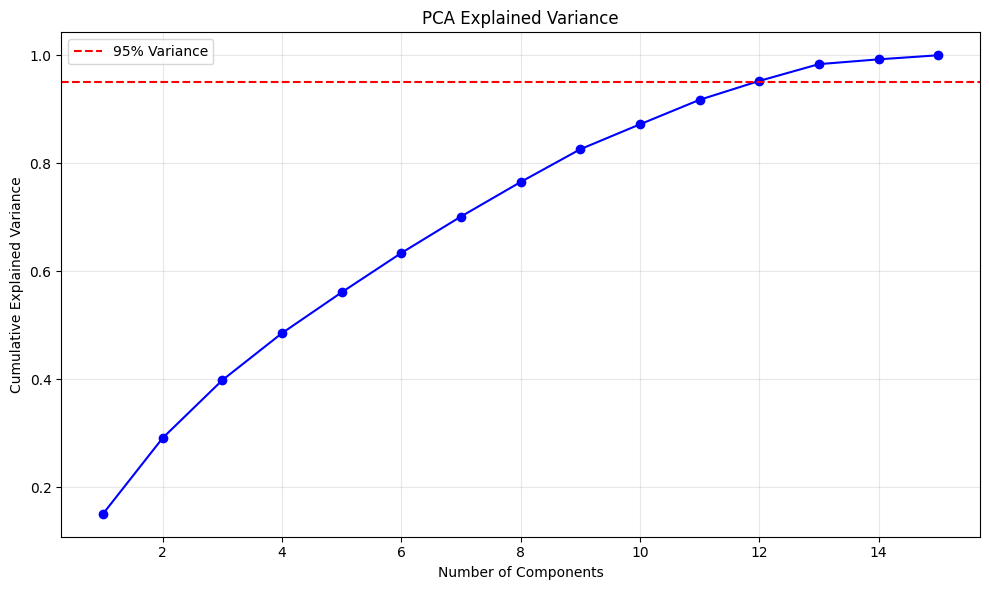

In [12]:
print("=" * 60)
print("DATA PREPROCESSING FOR CLUSTERING")
print("=" * 60)

# Standardize features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_segmentation)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_segmentation.columns, index=X_segmentation.index)

print(f"Data standardized. Shape: {X_scaled_df.shape}")
print(f"Mean of scaled features (should be ~0): {X_scaled_df.mean().mean():.6f}")
print(f"Std of scaled features (should be ~1): {X_scaled_df.std().mean():.6f}")

# Optional: PCA for dimensionality reduction (if needed)
# We'll use it as an option but also work with original features
pca = PCA(n_components=min(50, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_.cumsum()
n_components_95 = np.where(explained_variance >= 0.95)[0][0] + 1

print(f"\nPCA Analysis:")
print(f"  Components needed for 95% variance: {n_components_95}")
print(f"  Total components: {X_scaled.shape[1]}")

# Visualize explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, min(31, len(explained_variance)+1)), 
         explained_variance[:30], 'bo-')
plt.axhline(0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Although 12 variables capture most of the key information, we retained all 15 variables to preserve interpretability and ensure no potentially relevant customer characteristics are omitted. While some information may be partially redundant, including all variables allows clusters to be described in terms of all original features, making them more meaningful for business insights.

### A.3 Determining Optimal Number of Clusters with UMAP

UMAP was then applied to project the high-dimensional data into a 2D space, preserving both local and global structure. This allows similar customers to appear closer together.
 
The UMAP visualization helps identify natural cluster separations, providing guidance on the optimal number of clusters prior to applying clustering algorithms. Diferent scaler changes the visualization, making it important to choose the acording scaler to the problem

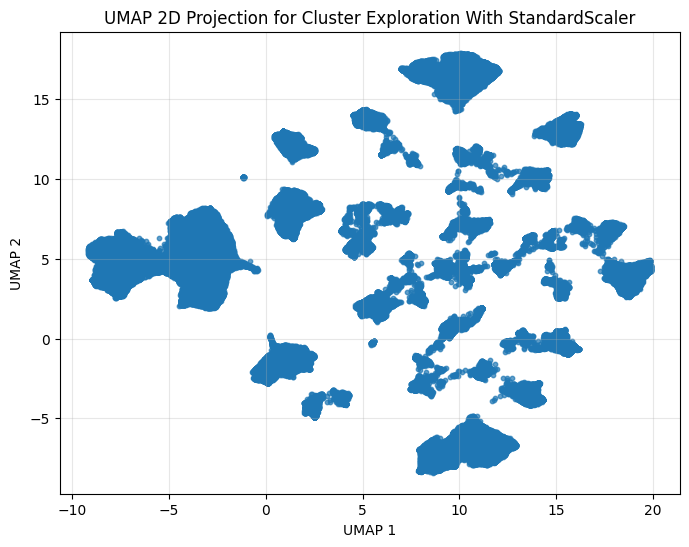

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_segmentation)

# Initialize UMAP
umap_reducer = umap.UMAP(
    n_neighbors=15,  # controls local vs global structure
    min_dist=0.1,    # controls spacing of points
    n_components=2,  # 2D for visualization
    random_state=42
)

# Fit and transform
X_umap = umap_reducer.fit_transform(X_scaled)

# Plot UMAP embedding
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.7)
plt.title("UMAP 2D Projection for Cluster Exploration With StandardScaler")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(alpha=0.3)
plt.show()

Around 10 to 14 segmentations can be visualized in this plot

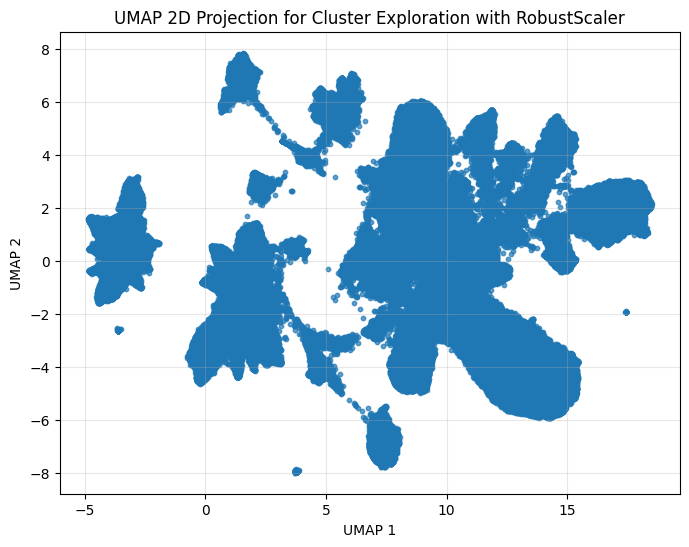

In [30]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_segmentation)

# Initialize UMAP
umap_reducer = umap.UMAP(
    n_neighbors=15,  # controls local vs global structure
    min_dist=0.1,    # controls spacing of points
    n_components=2,  # 2D for visualization
    random_state=42
)

# Fit and transform
X_umap = umap_reducer.fit_transform(X_scaled)

# Plot UMAP embedding
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.7)
plt.title("UMAP 2D Projection for Cluster Exploration with RobustScaler")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(alpha=0.3)
plt.show()

Around 6 to 7 clusters from this plot.

We will use Robust Scallers and try to look around for 6 to 7 clusters. Altough we have an initial number of clusters, each clustering techinique as weak and strong points,  so we will try to choose the best one according to Silhouette Score

### A.4 Determining Optimal Number of Clusters with Kmeans

Now we determine the optimal number of clusters by applying K-means with different values of k (from 2 to 10).
It evaluates each clustering using inertia (elbow method) and silhouette score, visualizes both metrics, and selects the optimal number of clusters based on the highest silhouette score.


In [6]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_segmentation)

DETERMINING OPTIMAL NUMBER OF CLUSTERS
Testing different numbers of clusters...
  k=4: Inertia=1227141.22, Silhouette=0.1599
  k=6: Inertia=1003655.06, Silhouette=0.1579
  k=8: Inertia=889325.15, Silhouette=0.1467

CLUSTER ANALYSIS RESULTS
   k       Inertia  Silhouette_Score
0  4  1.227141e+06            0.1599
1  6  1.003655e+06            0.1579
2  8  8.893252e+05            0.1467


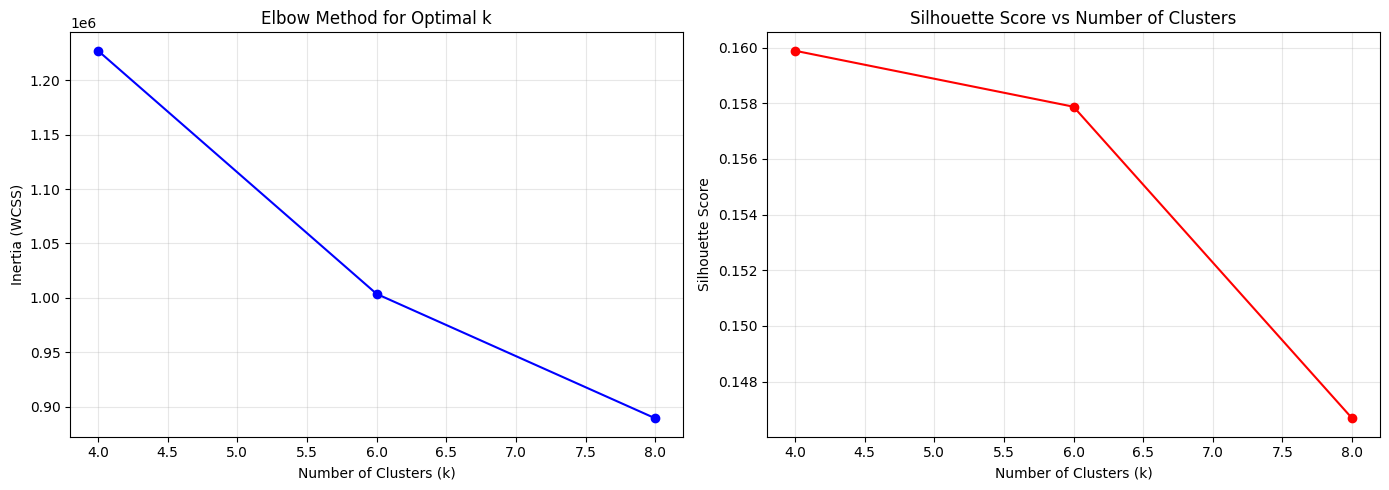


Optimal number of clusters (based on Silhouette Score): k=4
  Silhouette Score: 0.1599


In [20]:
print("=" * 60)
print("DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("=" * 60)

# Try different numbers of clusters
k_range = [4, 6, 8]
inertias = []
silhouette_scores = []

print("Testing different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette_avg)
    
    print(f"  k={k}: Inertia={inertia:.2f}, Silhouette={silhouette_avg:.4f}")

# Create results dataframe
cluster_analysis = pd.DataFrame({
    'k': list(k_range),
    'Inertia': inertias,
    'Silhouette_Score': silhouette_scores
})

print("\n" + "=" * 60)
print("CLUSTER ANALYSIS RESULTS")
print("=" * 60)
print(cluster_analysis.round(4))

# Visualize elbow method and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow method
ax = axes[0]
ax.plot(cluster_analysis['k'], cluster_analysis['Inertia'], 'bo-')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Inertia (WCSS)')
ax.set_title('Elbow Method for Optimal k')
ax.grid(alpha=0.3)

# Silhouette scores
ax = axes[1]
ax.plot(cluster_analysis['k'], cluster_analysis['Silhouette_Score'], 'ro-')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score vs Number of Clusters')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = cluster_analysis.loc[cluster_analysis['Silhouette_Score'].idxmax(), 'k']
optimal_silhouette = cluster_analysis.loc[cluster_analysis['Silhouette_Score'].idxmax(), 'Silhouette_Score']

print(f"\nOptimal number of clusters (based on Silhouette Score): k={int(optimal_k)}")
print(f"  Silhouette Score: {optimal_silhouette:.4f}")


Although k = 4 achieves a slightly better silhouette score, k = 6 performs very similarly while providing finer segmentation. This choice is also consistent with the UMAP analysis, which suggests the presence of approximately 6–7 meaningful clusters. Therefore, we select k = 6 as a better balance between cluster quality and granularity.

### A.5 K-Means Clustering


In [8]:
print("=" * 60)
print("K-MEANS CLUSTERING")
print("=" * 60)

# Apply K-Means with optimal k
kmeans_final = KMeans(n_clusters=int(6), random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to original data
data_with_clusters = data.copy()
data_with_clusters['Cluster_KMeans'] = kmeans_labels
    
print(f"K-Means clustering completed with k={int(6)}")
print(f"\nCluster distribution:")
print(pd.Series(kmeans_labels).value_counts().sort_index())

# Calculate silhouette score for final model
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"\nSilhouette Score: {kmeans_silhouette:.4f}")

# Store for comparison
clustering_results = {
    'K-Means': {
        'labels': kmeans_labels,
        'silhouette': kmeans_silhouette,
        'model': kmeans_final
    }
}


K-MEANS CLUSTERING
K-Means clustering completed with k=6

Cluster distribution:
0    14055
1    16747
2        1
3    68184
4    28343
5    31460
Name: count, dtype: int64

Silhouette Score: 0.1579


### A.6 Hierarchical Clustering


We also tried Hierarchical clustering using ward linkage but because of memory issues we couldn't use all dataset and reduced to 5000 random observations, because of this limitations we will not consider this aproch for avaluation

HIERARCHICAL CLUSTERING
Using sample of 5000 records for hierarchical clustering
Computing linkage matrix...


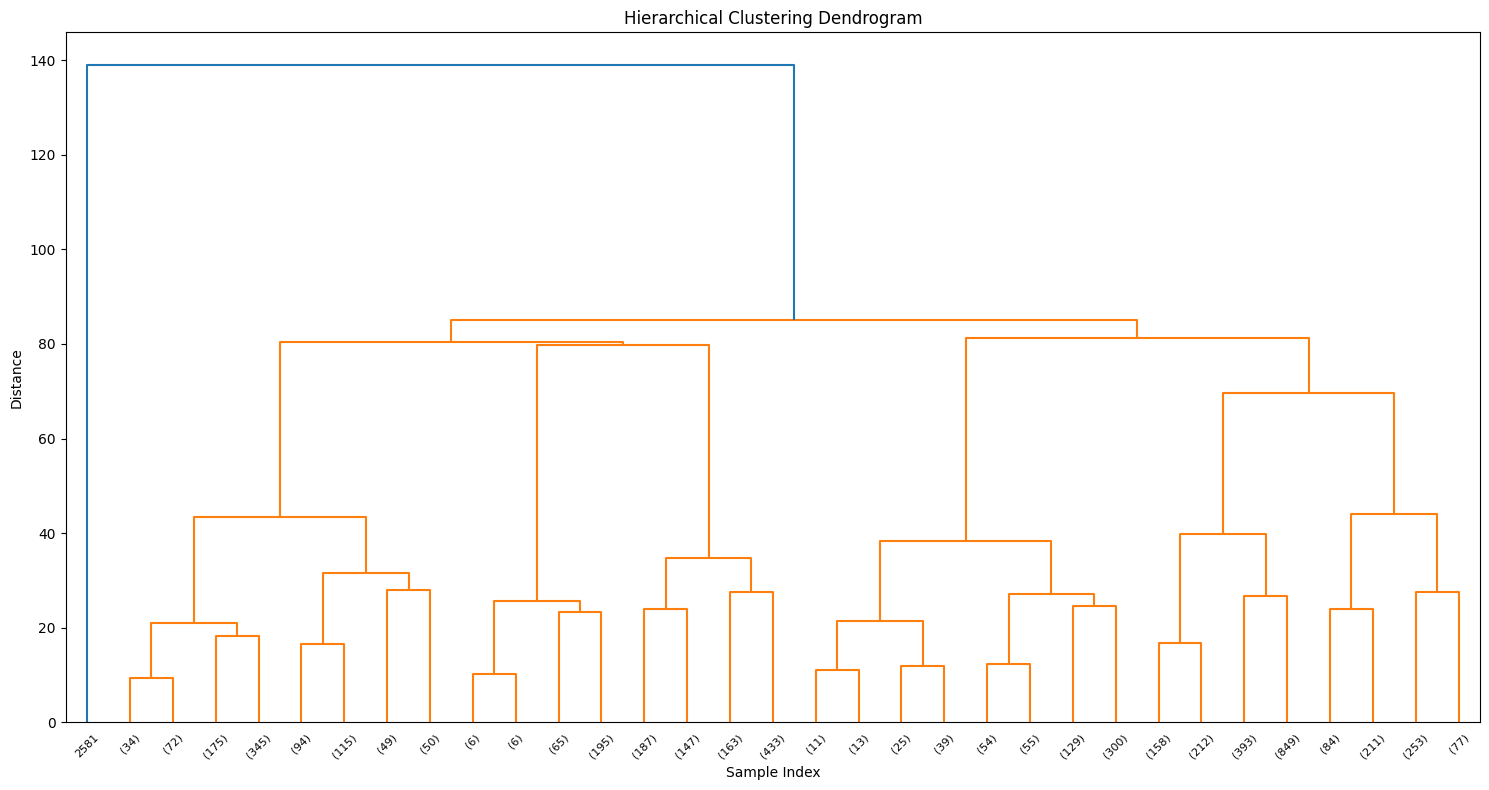

In [26]:
print("=" * 60)
print("HIERARCHICAL CLUSTERING")
print("=" * 60)

# Use a sample for hierarchical clustering if dataset is too large (computational efficiency)
sample_size = min(5000, len(X_scaled))
if len(X_scaled) > sample_size:
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    X_sample = X_scaled[sample_indices]
    print(f"Using sample of {sample_size} records for hierarchical clustering")
else:
    X_sample = X_scaled
    sample_indices = np.arange(len(X_scaled))

# Compute linkage matrix
print("Computing linkage matrix...")
linkage_matrix = linkage(X_sample, method='ward')

# Visualize dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [ ]:
# Cannot be applied because of memory issues on large datasets
"""""
# Apply Agglomerative Clustering with optimal k
print(f"\nApplying Agglomerative Clustering with k={int(9)}...")
hierarchical = AgglomerativeClustering(n_clusters=int(9), linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add cluster labels
data_with_clusters['Cluster_Hierarchical'] = hierarchical_labels

print(f"Hierarchical clustering completed")
print(f"\nCluster distribution:")
print(pd.Series(hierarchical_labels).value_counts().sort_index())

# Calculate silhouette score
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
print(f"\nSilhouette Score: {hierarchical_silhouette:.4f}")

# Store for comparison
clustering_results['Hierarchical'] = {
    'labels': hierarchical_labels,
    'silhouette': hierarchical_silhouette,
    'model': hierarchical
}
""""""""

### A.7 DBSCAN Clustering


In [28]:
print("=" * 60)
print("DBSCAN CLUSTERING")
print("=" * 60)

# DBSCAN doesn't require specifying number of clusters
# We need to tune eps and min_samples parameters
# Try different parameter combinations
eps_values = [1, 2]
min_samples_values = [10]

dbscan_results = []

print("Testing different DBSCAN parameters...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        if n_clusters > 1:  # Only calculate silhouette if we have more than 1 cluster
            try:
                silhouette = silhouette_score(X_scaled, dbscan_labels)
            except:
                silhouette = -1
        else:
            silhouette = -1
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette
        })
        
        print(f"  eps={eps}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} noise points, silhouette={silhouette:.4f}")

dbscan_df = pd.DataFrame(dbscan_results)
dbscan_df = dbscan_df[dbscan_df['silhouette'] > 0]  # Filter valid results

if len(dbscan_df) > 0:
    best_dbscan = dbscan_df.loc[dbscan_df['silhouette'].idxmax()]
    print(f"\nBest DBSCAN parameters:")
    print(f"  eps: {best_dbscan['eps']}")
    print(f"  min_samples: {int(best_dbscan['min_samples'])}")
    print(f"  n_clusters: {int(best_dbscan['n_clusters'])}")
    print(f"  silhouette: {best_dbscan['silhouette']:.4f}")
    
    # Apply best DBSCAN
    dbscan_final = DBSCAN(eps=best_dbscan['eps'], min_samples=int(best_dbscan['min_samples']))
    dbscan_labels = dbscan_final.fit_predict(X_scaled)
    
    data_with_clusters['Cluster_DBSCAN'] = dbscan_labels
    
    print(f"\nCluster distribution:")
    print(pd.Series(dbscan_labels).value_counts().sort_index())
    
    # Store for comparison
    clustering_results['DBSCAN'] = {
        'labels': dbscan_labels,
        'silhouette': best_dbscan['silhouette'],
        'model': dbscan_final,
        'n_clusters': int(best_dbscan['n_clusters'])
    }
else:
    print("\nNo suitable DBSCAN parameters found. Skipping DBSCAN.")


DBSCAN CLUSTERING
Testing different DBSCAN parameters...
  eps=1, min_samples=10: 144 clusters, 54919 noise points, silhouette=-0.3182
  eps=2, min_samples=10: 1 clusters, 1196 noise points, silhouette=-1.0000

No suitable DBSCAN parameters found. Skipping DBSCAN.


### A.8 Mean-shift Clustering

In [35]:
print("=" * 60)
print("MEAN SHIFT CLUSTERING")
print("=" * 60)

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score

# Try different quantiles to estimate bandwidth
quantile_values = [ 1, 0.8]

meanshift_results = []

print("Testing different Mean Shift bandwidths...")
for quantile in quantile_values:
    try:
        bandwidth = estimate_bandwidth(X_scaled, quantile=quantile, n_samples=500)
        
        if bandwidth <= 0:
            continue
        
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms_labels = ms.fit_predict(X_scaled)
        
        n_clusters = len(set(ms_labels))
        
        if n_clusters > 1:
            try:
                silhouette = silhouette_score(X_scaled, ms_labels)
            except:
                silhouette = -1
        else:
            silhouette = -1
        
        meanshift_results.append({
            'quantile': quantile,
            'bandwidth': bandwidth,
            'n_clusters': n_clusters,
            'silhouette': silhouette
        })
        
        print(f"  quantile={quantile}: bandwidth={bandwidth:.4f}, "
              f"{n_clusters} clusters, silhouette={silhouette:.4f}")
    
    except Exception as e:
        print(f"  quantile={quantile}: failed ({e})")

ms_df = pd.DataFrame(meanshift_results)
ms_df = ms_df[ms_df['silhouette'] > 0]

if len(ms_df) > 0:
    best_ms = ms_df.loc[ms_df['silhouette'].idxmax()]
    
    print(f"\nBest Mean Shift parameters:")
    print(f"  quantile: {best_ms['quantile']}")
    print(f"  bandwidth: {best_ms['bandwidth']:.4f}")
    print(f"  n_clusters: {int(best_ms['n_clusters'])}")
    print(f"  silhouette: {best_ms['silhouette']:.4f}")
    
    # Apply best Mean Shift
    ms_final = MeanShift(
        bandwidth=best_ms['bandwidth'],
        bin_seeding=True
    )
    ms_labels = ms_final.fit_predict(X_scaled)
    
    data_with_clusters['Cluster_MeanShift'] = ms_labels
    
    print(f"\nCluster distribution:")
    print(pd.Series(ms_labels).value_counts().sort_index())
    
    # Store for comparison
    clustering_results['MeanShift'] = {
        'labels': ms_labels,
        'silhouette': best_ms['silhouette'],
        'model': ms_final,
        'n_clusters': int(best_ms['n_clusters'])
    }
else:
    print("\nNo suitable Mean Shift parameters found. Skipping Mean Shift.")


MEAN SHIFT CLUSTERING
Testing different Mean Shift bandwidths...
  quantile=1: bandwidth=9.3845, 8 clusters, silhouette=0.7797
  quantile=0.8: bandwidth=4.8289, 14 clusters, silhouette=0.6214

Best Mean Shift parameters:
  quantile: 1.0
  bandwidth: 9.3845
  n_clusters: 8
  silhouette: 0.7797

Cluster distribution:
0    158750
1        31
2         2
3         3
4         1
5         1
6         1
7         1
Name: count, dtype: int64


### B. Best Segmentation Selection

Now we'll compare the different clustering approaches and select the best one.


| Algorithm   | Number of Clusters | Silhouette Score |
|------------|--------------------|------------------|
| Mean Shift | 8                  | 0.7797           |
| DBSCAN     | 144                | -0.3182          |
| K-Means    | 6                  | 0.1579           |


| Mean Shift (8 clusters) | Samples | K-Means (6 clusters) | Samples |
|------------------------:|--------:|----------------------:|--------:|
| Cluster 0 | 158,750 | Cluster 0 | 14,055 |
| Cluster 1 | 31 | Cluster 1 | 16,747 |
| Cluster 2 | 2 | Cluster 2 | 1 |
| Cluster 3 | 3 | Cluster 3 | 68,184 |
| Cluster 4 | 1 | Cluster 4 | 28,343 |
| Cluster 5 | 1 | Cluster 5 | 31,460 |
| Cluster 6 | 1 | — | — |
| Cluster 7 | 1 | — | — |


We choose K-Means with 6 clusters because it provides a more generalized and balanced segmentation compared to the other methods. Unlike Mean Shift, which produces highly imbalanced clusters, K-Means yields interpretable group sizes. However, Cluster 2 contains only one customer and will be removed as it does not represent a meaningful segment.

### C. Segment Profiling and Interpretation

Now we'll analyze each segment to understand their characteristics and create business-friendly names.


In [19]:
print("=" * 60)
print("SEGMENT PROFILING – K-MEANS (k=6)")
print("=" * 60)

# Key features for profiling
key_profile_features = [
    "CREDIT_INCOME_RATIO",
    "ANNUITY_INCOME_RATIO",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "CNT_FAM_MEMBERS",
    "CNT_CHILDREN",
    "FLAG_OWN_REALTY",
    "FLAG_OWN_CAR",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "REGION_POPULATION_RELATIVE",
    "REGION_RATING_CLIENT",
    "CREDIT_GOODS_RATIO"
]

# Keep only features that exist in the dataset
available_profile_features = [
    f for f in key_profile_features if f in data_with_clusters.columns
]

segment_profiles = []

# Loop through K-Means clusters
for cluster_id in sorted(data_with_clusters['Cluster_KMeans'].unique()):
    
    cluster_data = data_with_clusters[
        data_with_clusters['Cluster_KMeans'] == cluster_id
    ]
    
    cluster_size = len(cluster_data)
    cluster_pct = (cluster_size / len(data_with_clusters)) * 100
    
    profile = {
        'Cluster': cluster_id,
        'Size': cluster_size,
        'Percentage': cluster_pct
    }
    
    # Compute statistics
    for feature in available_profile_features:
        if np.issubdtype(cluster_data[feature].dtype, np.number):
            profile[f'{feature}_mean'] = cluster_data[feature].mean()
            profile[f'{feature}_median'] = cluster_data[feature].median()
        else:
            profile[f'{feature}_mode'] = (
                cluster_data[feature].mode()[0]
                if not cluster_data[feature].mode().empty
                else 'N/A'
            )
    
    segment_profiles.append(profile)

# Create DataFrame
segment_profiles_df = pd.DataFrame(segment_profiles)

print("\nSegment Profiles (Key Statistics):")
display_cols = (
    ['Cluster', 'Size', 'Percentage'] +
    [c for c in segment_profiles_df.columns if c.endswith('_mean')]
)
display(segment_profiles_df[display_cols].round(2))

#remove cluster 2
segment_profiles_df = segment_profiles_df[segment_profiles_df['Cluster'] != 2]


SEGMENT PROFILING – K-MEANS (k=6)

Segment Profiles (Key Statistics):


,Cluster,Size,Percentage,CREDIT_INCOME_RATIO_mean,ANNUITY_INCOME_RATIO_mean,AMT_INCOME_TOTAL_mean,AMT_CREDIT_mean,DAYS_BIRTH_mean,DAYS_EMPLOYED_mean,CNT_FAM_MEMBERS_mean,CNT_CHILDREN_mean,FLAG_OWN_REALTY_mean,FLAG_OWN_CAR_mean,OBS_30_CNT_SOCIAL_CIRCLE_mean,DEF_30_CNT_SOCIAL_CIRCLE_mean,REGION_POPULATION_RELATIVE_mean,REGION_RATING_CLIENT_mean,CREDIT_GOODS_RATIO_mean
0,0,14055,8.85,3.96,0.17,1.982248e+05,696103.80,48.60,20.41,2.01,0.25,0.72,0.34,1.05,0.11,0.02,2.04,1.12
1,1,16747,10.55,3.76,0.18,1.597828e+05,566024.79,44.00,5.19,2.07,0.33,0.72,0.33,6.62,0.47,0.02,2.10,1.13
2,2,1,0.00,0.00,0.00,1.170000e+08,562491.00,35.00,2.53,3.00,1.00,1.00,0.00,0.00,0.00,0.01,2.00,1.24
3,3,68184,42.94,2.73,0.14,1.757575e+05,462895.48,44.71,4.28,1.64,0.05,0.69,0.31,0.66,0.10,0.02,2.03,1.12
4,4,28343,17.85,7.86,0.31,1.270038e+05,954598.68,46.77,5.05,2.05,0.23,0.67,0.29,0.90,0.12,0.02,2.12,1.13
5,5,31460,19.81,3.19,0.16,1.797690e+05,537497.80,36.28,4.91,3.49,1.53,0.69,0.44,0.94,0.11,0.02,2.07,1.13


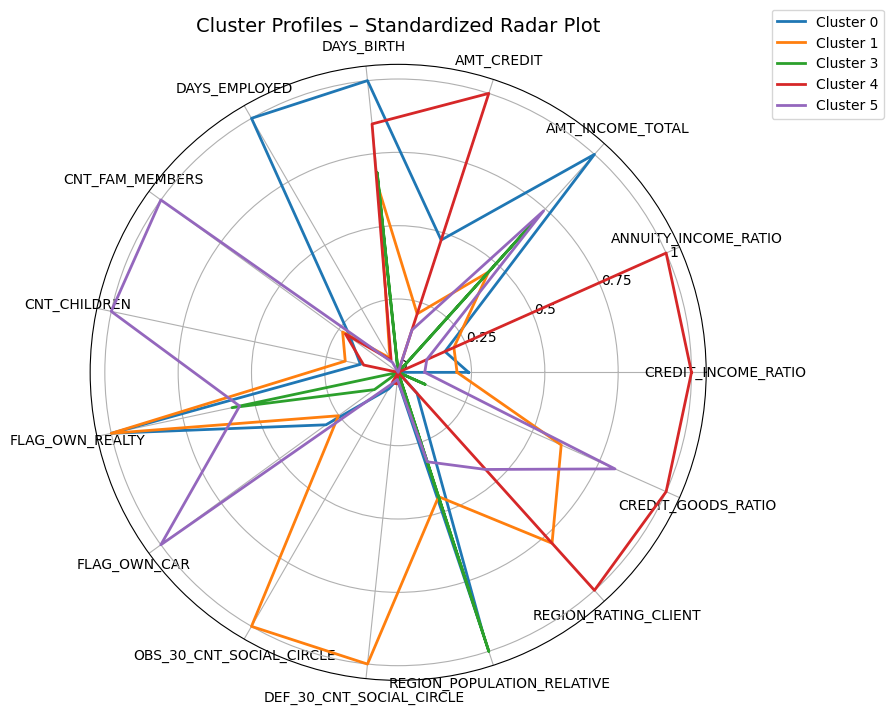

In [32]:
from math import pi
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Select features for the spider plot (mean features)
mean_features = [c for c in segment_profiles_df.columns if c.endswith("_mean")]

# Optional: pick top 8–10 features for readability
features_to_plot = mean_features[:16]

# Standardize features 0–1
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(
    scaler.fit_transform(segment_profiles_df[features_to_plot]),
    columns=features_to_plot,
    index=segment_profiles_df['Cluster']
)

num_features = len(features_to_plot)
angles = [n / float(num_features) * 2 * pi for n in range(num_features)]
angles += angles[:1]  # close the circle

plt.figure(figsize=(8,8))

for idx, row in scaled_data.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]  # close the circle
    plt.polar(angles, values, linewidth=2, label=f"Cluster {idx}")

plt.xticks(angles[:-1], [f.replace("_mean","") for f in features_to_plot], fontsize=10)
plt.yticks([0,0.25,0.5,0.75,1], ["0","0.25","0.5","0.75","1"])
plt.title("Cluster Profiles – Standardized Radar Plot", fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
plt.show()




As we can see, our clusters have diferent carachteristics

### C.1 Segment Naming and Business Interpretation

Based on the segment profiles, we'll create business-friendly names and descriptions for each segment.


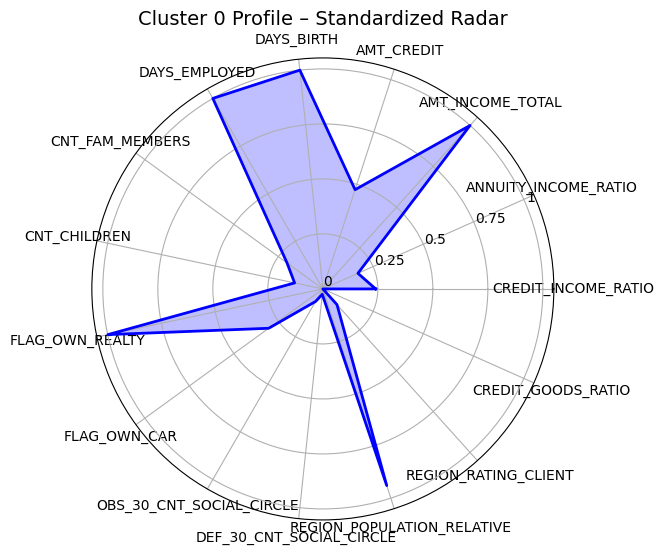

In [39]:

from math import pi
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Function to plot individual cluster radar (fixed)
def plot_cluster_radar(cluster_id, df, features=None, top_n=20):
    """
    Plots a standardized radar plot for a specific cluster.

    Parameters:
    - cluster_id: int, ID of the cluster to plot
    - df: pandas DataFrame, must include 'Cluster' column and mean features (ending with '_mean')
    - features: list of columns to plot (optional, defaults to *_mean)
    - top_n: int, number of features to plot if features not provided
    """
    # Select mean features if not provided
    if features is None:
        mean_features = df.filter(regex=r'_mean$').columns.tolist()
        if not mean_features:
            print("No '_mean' features found in DataFrame.")
            return
        features_to_plot = mean_features[:top_n]
    else:
        features_to_plot = list(features)

    if len(features_to_plot) == 0:
        print("No features to plot.")
        return

    # Check features exist
    missing = [f for f in features_to_plot if f not in df.columns]
    if missing:
        print(f"Missing features in DataFrame: {missing}")
        return

    if 'Cluster' not in df.columns:
        print("DataFrame must contain a 'Cluster' column.")
        return

    # Prepare values (index by Cluster)
    values_df = df.set_index('Cluster')[features_to_plot]

    # Scale 0-1
    scaler = MinMaxScaler()
    try:
        scaled_vals = scaler.fit_transform(values_df.astype(float).fillna(0))
    except Exception as e:
        print("Scaling failed:", e)
        return

    scaled_data = pd.DataFrame(scaled_vals, columns=features_to_plot, index=values_df.index)

    if cluster_id not in scaled_data.index:
        print(f"Cluster {cluster_id} not found.")
        return

    values = scaled_data.loc[cluster_id].tolist()
    values += values[:1]  # close the circle

    num_features = len(features_to_plot)
    angles = [n / float(num_features) * 2 * pi for n in range(num_features)]
    angles += angles[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2, color='b')
    ax.fill(angles, values, alpha=0.25, color='b')

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([f.replace("_mean", "") for f in features_to_plot], fontsize=10)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels(["0", "0.25", "0.5", "0.75", "1"])
    ax.set_title(f"Cluster {cluster_id} Profile – Standardized Radar", fontsize=14)
    plt.show()

# Example usage:
plot_cluster_radar(0, segment_profiles_df)  # plots cluster 0




### 📊 Profile Cluster 0 – “Affluent, Long-Tenured Homeowners” 

*   **High income**
*   **Long employment history, older age**
*   **Very high real estate ownership**
*   **Low credit pressure** (low credit/income & annuity/income ratios)
*   **Low social-circle default exposure**
*   **Small households/ family**
*   **Lives on high density places**

---

### 📝 Interpretation

This is the most financially stable and conservative group. They borrow modestly relative to income, are well established in their careers, and have strong asset backing.

---

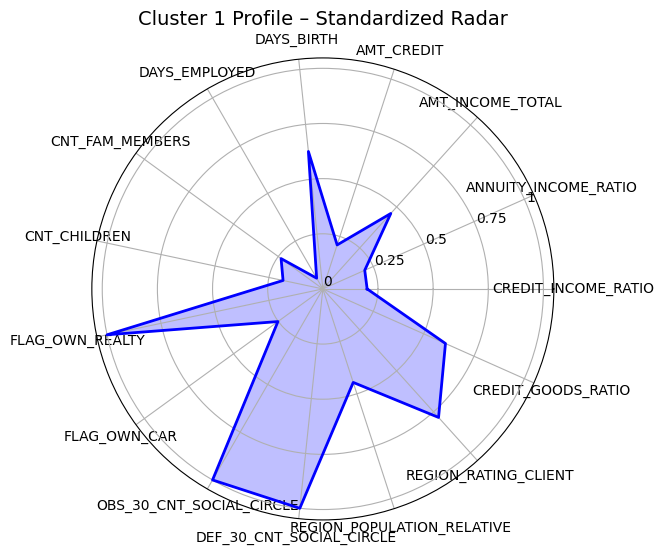

In [40]:
plot_cluster_radar(1, segment_profiles_df) 

### 🔑 Key Characteristics Cluster 1 – “Credit-Stressed, Social-Risk Exposed Borrowers”
 
*   **High defaulted social circle counts**
*   **Real estate ownership still common**
*   **Uneployed or recent employed**
*   **Low income**
*   **Medium credit goods ratio** → purchases rely on borrowed money
---

### 📝 Interpretation

Applicants in this cluster are financially active but exposed to elevated risk signals, especially through their social circle and recent or non employment, suggesting potential repayment stress.

---


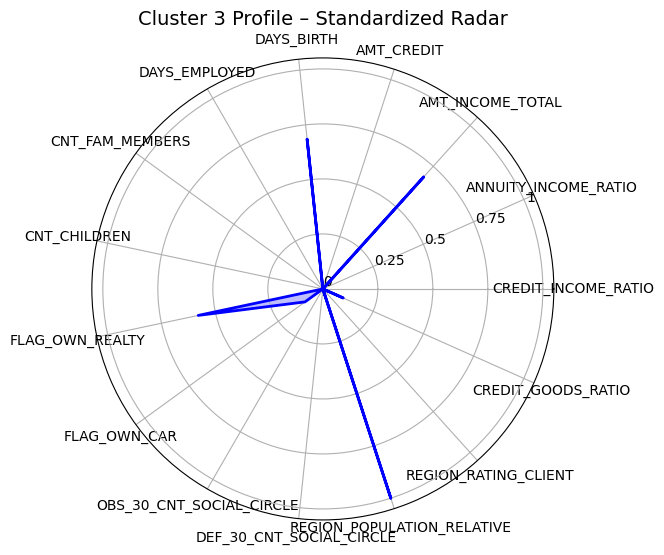

In [55]:
plot_cluster_radar(3, segment_profiles_df) 

### 🔑 Key Characteristics Cluster 3 – “Asset-Rich, Income-Unstable Urbanites”
 
*   **Moderate- high income**
*   **Real estate ownership still common**
*   **Uneployed or recent employed**
*   **Lives on high density places**
*   **Low credit pressure** 
---

### 📝 Interpretation

This segment holds valuable assets (real estate) and has moderate-high income potential, but faces employment instability. Their low credit pressure suggests they are either financially cautious, use savings, or have alternative income sources. High-density living may correlate with urban professionals in transitional career phases.

---



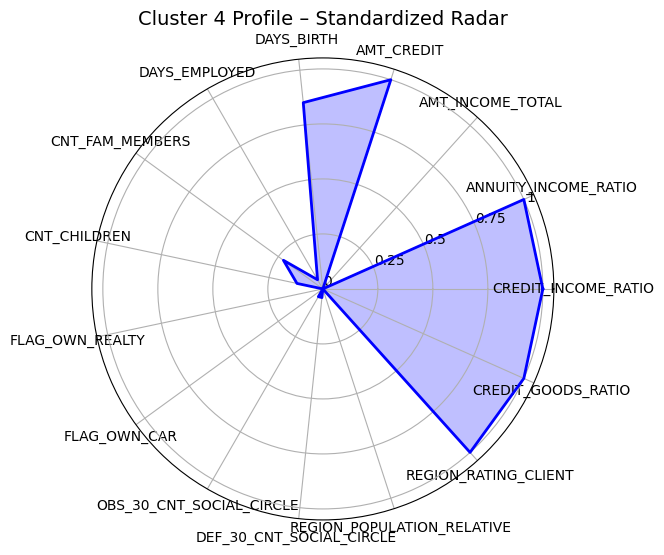

In [43]:
plot_cluster_radar(4, segment_profiles_df) 

### 🔑 Key Characteristics Cluster 4 – “Overleveraged Distressed”
 
*   **High credit loans**
*   **Very low income**
*   **Recent or no employment**
*   **High annuity_income_ratio**
*   **High credit_income_ratio**
*   **High credit_good_ratio** 
*   **Lives on worstly rated area**

---

### 📝 Interpretation

This cluster represents the highest-risk applicants in the portfolio. They are characterized by a dangerous imbalance: extremely high debt obligations against a backdrop of very low and unstable income. The critical warning signs are the high annuity_income_ratio and credit_income_ratio, which signal that debt servicing costs likely exceed their ability to pay. Their high credit_goods_ratio suggests reliance on credit for basic purchases, while living in a low-rated area adds environmental socioeconomic stress. This combination creates a high probability of immediate or near-term default.

---


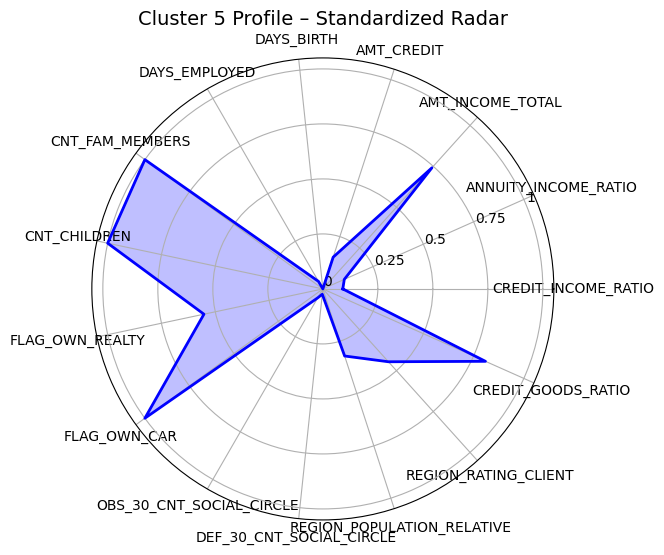

In [44]:
plot_cluster_radar(5, segment_profiles_df) 

### 🔑 Key Characteristics Cluster 5 – “Leveraged Affluent Families”
 
*   **High family**
*   **Have children**
*   **Has a car and ownership of home is common**
*   **Income high**
*   **High Credit to goods ratio** 
---

### 📝 Interpretation

This cluster consists of high-income, asset-owning households with children. Despite their strong financial footing, they exhibit a high credit-to-goods ratio, suggesting they systematically use credit for a significant portion of their spending. This could reflect financial sophistication (e.g., optimizing rewards, managing cash flow) or could indicate lifestyle inflation where spending keeps pace with—or exceeds—their substantial income. They are valuable customers but warrant monitoring for signs of overleveraging relative to their assets.

---


### **Portfolio Cluster Summary**

| Cluster | Name | Risk Level | Core Theme |
|:---:|:---|:---:|:---|
| **0** | Affluent, Long-Tenured Homeowners | Very Low | Wealth + Stability |
| **1** | Credit-Stressed, Social-Risk Exposed Borrowers | High | Environmental and sistemic Risk |
| **3** | Asset-Rich, Income-Unstable Urbanites | Medium | income instability |
| **4** | Overleveraged Distressed | Very High | Structural Affordability Risk |
| **5** | Leveraged Affluent Families | Medium-low | Cash-Flow Constrained |

### C.2 Business Implications and Recommendations

### 📊 Profile Cluster 0 – “Affluent, Long-Tenured Homeowners” 

This is the most financially stable and conservative group. They borrow modestly relative to income, are well established in their careers, and have strong asset backing.


### ⚠️ Risk View
**✅ Lowest risk segment**



### 🎯 Typical Strategy

*   Premium products
*   Higher credit limits
*   Fast-track approvals

---
---

### 📊  Cluster 1 – “Credit-Stressed, Social-Risk Exposed Borrowers”
Applicants in this cluster are financially active but exposed to elevated risk signals, especially through their social circle and recent or non employment, suggesting potential repayment stress.


### ⚠️ Risk View
**high risk segment**

Primary risk is over-indebtedness driven by social influence, worsened by low/unstable income, and amplified by reliance on credit for purchases, resulting in a high overall default risk.

### ⚠️ Business Meaning
This is a classic subprime, high-default-probability segment. The risks are interconnected and systemic to their financial profile.


### 🎯 Typical Strategy
*   Requires stricter underwriting - Apply stricter debt-to-income thresholds and verify employment
*   Requires closer monitoring - Flag for early delinquency follow-up
*   May need pricing adjustments

---
---

### 📊  Cluster 3 – “Asset-Rich, Income-Unstable Urbanites”
This segment holds valuable assets (real estate) and has moderate-high income potential, but faces employment instability. Their low credit pressure suggests they are either financially cautious, use savings, or have alternative income sources. High-density living may correlate with urban professionals in transitional career phases.


### ⚠️ Risk View
**Medium risk segment**

Main risk is income instability limiting debt repayment despite real estate assets, mitigated by low existing leverage and careful financial behavior.

### ⚠️ Business Meaning
Risk is not systemic across their finances but is acute in one critical area: income verification and stability.


### 🎯 Typical Strategy
*   Provide flexible repayment terms to handle income volatility
*   Avoid overexposure to unsecured debt
*   Monitor cash flow to ensure debt servicing capacity

---
---


### 📊  Cluster 4 – “Asset-Rich, Income-Unstable Urbanites”
This segment holds valuable assets (real estate) and has moderate-high income potential, but faces employment instability. Their low credit pressure suggests they are either financially cautious, use savings, or have alternative income sources. High-density living may correlate with urban professionals in transitional career phases.


### ⚠️ Risk View
**Very High risk segment**

Clients face near-certain default due to extremely low income, high debt relative to resources, no safety net, and reliance on credit for essentials.

### ⚠️ Business Meaning
This is the highest-risk segment in a lending portfolio. The probability of charge-off is extreme.

### 🎯 Typical Strategy
*   Limit new lending; avoid taking on additional unsecured debt.
*   Closely monitor cash flow and repayment capacity.
*   Prioritize risk mitigation over growth; consider restructuring existing debt rather than expanding exposure.

---
---


### 📊  Cluster 5 – “Leveraged Affluent Families”
This segment holds valuable assets (real estate) and has moderate-high income potential, but faces employment instability. Their low credit pressure suggests they are either financially cautious, use savings, or have alternative income sources. High-density living may correlate with urban professionals in transitional career phases.


### ⚠️ Risk View
**Medium-low**

Primary risk is lifestyle-driven overconfidence and rising fixed obligations that could strain cash flow, but strong income and asset buffers provide meaningful resilience.

### ⚠️ Business Meaning
The risk is not of insolvency, but of cash flow stress and potential strategic default if overextended. Defaults would be rare but could involve large balances.

### 🎯 Typical Strategy
*   Offer premium, structured credit (mortgages, auto, wealth-backed loans) rather than unsecured consumer credit.
*   Set conservative affordability limits to prevent lifestyle creep.
*   Encourage liquidity buffers (savings, offset accounts, revolving credit lines).
*   Monitor fixed-obligation ratios (housing, education, auto).

---
---